<a href="https://colab.research.google.com/github/Dummy-Bug/Amazon-Fine-Food-Reviews/blob/master/3%20Naive%20Bayes/Amazon_Fine_Food_Reviews_using_Naive_Bayes_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
! sudo pip install imbalanced-learn

In [ ]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.1


# [1]. Reading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# using the SQLite Table to read data.
con = sqlite3.connect('/content/drive/MyDrive/Data sets/database.sqlite') 
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score = 3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# * for tsne assignment you can take 5k data points *

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 limit 20000 """, con)
print("Number of data points in our data", filtered_data.shape)
filtered_data.head()


Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food pr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanuts...the pe...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a few centurie...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robituss...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wide assortme...


In [ ]:
filtered_data['Score'].value_counts()

5    13745
4     3110
1     1953
2     1192
Name: Score, dtype: int64

let's make the dataset balanced using Undersampling

In [ ]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0 # 0 here means negative review
    return 1 # it means review is positive

# changing reviews with score less than 3 to be positive and vice-versa

actualScore = filtered_data['Score']
positiveNegative = actualScore.apply(partition) # we can use .apply() also but .map is preffered for series
filtered_data['Score'] = positiveNegative

print("Number of data points in our data", filtered_data.shape)
filtered_data

Number of data points in our data (20000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food pr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanuts...the pe...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a few centurie...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robituss...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wide assortme...
...,...,...,...,...,...,...,...,...,...,...
19995,21784,B000KV61FC,A3FVKI0UH9DO2A,S. Malosh,1,1,1,1319414400,Occupies my dog for hours!,My 5-month-old Black Lab/Boston Terrier mix is a very cu...
19996,21785,B000KV61FC,A3ACVJEAM4L2LQ,Elb,1,1,1,1319155200,Keeps my big Dog busy for a long time!,My Doberman/pointer mix has a lot of extra energy and re...
19997,21786,B000KV61FC,AHHWZ4723VGOL,Sherry Lynn,1,1,0,1318809600,poor quality !!!!,This is a poor excuse for a dog toy . It lasted all of t...
19998,21787,B000KV61FC,A2O4CZ102I8Q2K,jus42day,1,1,1,1316649600,Great Product.,I bought this item unsure if my dogs would like it. Not ...


In [ ]:
filtered_data["Score"].value_counts()

1    16855
0     3145
Name: Score, dtype: int64

In [ ]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con) # selecting the reviews from only those users who have reviewed more than one products. 

In [ ]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price of other ...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, usually lat...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not eligible f...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the fridge if...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling you why I d...,2


In [ ]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews
where UserId = 'AZY10LLTJ71NX'
""", con) # selecting all the reviews posted by User

data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,35174,B001ATMQK2,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1296691200,Have you seen how much Ranch 99 is trying to charge!!,I bought this 6 pack because for the price that my local...
1,332195,B001P7AXXG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",1,1,5,1303776000,BEST MICROWAVE POPCORN EVER!!!!,This popcorn is probably the best microwave popcorn you ...
2,333057,B000MYW2ZA,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to lose weigh...
3,340773,B0043CVIBG,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",4,4,5,1303776000,girl scout thin mint in disguise,"if you love thin mint cookies that the girl scouts sell,..."
4,404703,B006P7E5ZI,AZY10LLTJ71NX,"undertheshrine ""undertheshrine""",0,0,5,1334707200,works for me. lost 10-15 pounds my first month,I was recommended to try green tea extract to lose weigh...


In [ ]:
data = pd.read_sql_query("""
SELECT count(*)
FROM Reviews
where UserId = 'AZY10LLTJ71NX'
""", con) # selecting all the reviews posted by User

data  # it will count all the reviews 

,count(*)
0,5


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to lose weigh...,5


In [ ]:
display[display['UserId']=='AZY10LLTJ71NX']['Text']

80638    I was recommended to try green tea extract to lose weigh...
Name: Text, dtype: object

https://stackoverflow.com/questions/25351968/how-can-i-display-full-non-truncated-dataframe-information-in-html-when-conver

In [ ]:
pd.set_option('display.max_colwidth', None) # to view the whoole text.
display[display['UserId']=='AZY10LLTJ71NX']['Text']

80638    I was recommended to try green tea extract to lose weight.  my first month I lost 10-15lbs.  I will continue taking these to see how well they work in the long term.
Name: Text, dtype: object

In [ ]:
display['COUNT(*)'].sum() # Number of Unique review givers.

393063

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ARE LESS SWEET ( LESS SUGAR AND CARBOHYDRATES) BUT VERY DELECTABLE.
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ARE LESS SWEET ( LESS SUGAR AND CARBOHYDRATES) BUT VERY DELECTABLE.
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ARE LESS SWEET ( LESS SUGAR AND CARBOHYDRATES) BUT VERY DELECTABLE.
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ARE LESS SWEET ( LESS SUGAR AND CARBOHYDRATES) BUT VERY DELECTABLE.
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ARE LESS SWEET ( LESS SUGAR AND CARBOHYDRATES) BUT VERY DELECTABLE.


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

https://github.com/Dummy-Bug/AI-and-ML/blob/master/Pandas/sort_values_and_sort_index.ipynb

In [ ]:
# Sorting data according to ProductId in ascending order
sorted_data = filtered_data.sort_values(by = ['ProductId'], axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html

In [ ]:
# Deduplication of entries
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(19354, 10)

In [ ]:
# Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

96.77

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

https://towardsdatascience.com/6-pandas-display-options-you-should-memories-84adf8887bc3

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate ordering this for him. He says they are great. I have tried them myself and they are delicious. Just open and pop them in the microwave. It is very easy. The best thing about ordering from Amazon grocery is that they deliver to your door. If you have a loved one that lives far away and may have limited transportation this is the answer. Just order what you want them to have and Amazon takes care of the rest.
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,"It was almost a 'love at first bite' - the perfectly roasted almond with a nice thin layer of pure flavorful cocoa on the top.<br /><br />You can smell the cocoa as soon as you open the canister - making you want to take a bite.<br /><br />You may or may not like the taste of this cocoa roasted almonds depending on your likingness for cocoa. We are so much used to the taste of chocolate (which is actually cocoa + many other ingredients like milk ...) - that you might have never really tasted really cocoa.<br /><br />Tasting this item it like tasting and enjoying flavorful pure raw cocoa with crunchy almonds in the center. Get yourself a box and see for yourself what real cocoa + almonds is !<br /><br />Where this product loses a star is in its packaging - the external sleeve is kind of comes in one piece, so if you try to remove the lid, the external sleeve kind of tends to come off fully - so careful when you are removing the external sleeve for the canister."


In [ ]:
pd.set_option('display.max_colwidth', 60)
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate ordering thi...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the perfectly roa...


In [ ]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(19354, 10)


1    16339
0     3015
Name: Score, dtype: int64

Datset is Highly Imbalanced !!

https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification//


In [ ]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons. Can't b...
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is available fo...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final product is out...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly wait to try...
8696,9527,B00005V3DC,A8KY7S48EW7LW,"A. Daly ""AD""",0,0,1,1350172800,The Best Cleansing Tea I've Ever Had,I've used this brand for years. If you're feeling clogge...


In [ ]:
final.reset_index()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons. Can't b...
1,2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is available fo...
2,1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final product is out...
3,1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly wait to try...
4,8696,9527,B00005V3DC,A8KY7S48EW7LW,"A. Daly ""AD""",0,0,1,1350172800,The Best Cleansing Tea I've Ever Had,I've used this brand for years. If you're feeling clogge...
...,...,...,...,...,...,...,...,...,...,...,...
19349,11590,12621,B009KP6HBM,A3UCO959VA9MV,Maryann Wardach,0,0,1,1299024000,cappucino t-discs,Some product work needs to be done on the discs. I have ...
19350,11588,12619,B009KP6HBM,A20NB4UBW4WDKG,"Gerardo ""GD""",1,1,1,1293321600,Coffe shop quality capuccino at home,I love coffee. Usually I would not recommend Maxwell Hou...
19351,11589,12620,B009KP6HBM,A3D9NUCR4RXDPY,Kathleen San Martino,1,1,1,1292544000,"Very,Very Good",This cappuccino is very good and tastes almost as good a...
19352,1362,1478,B009UOFU20,AJVB004EB0MVK,D. Christofferson,0,0,0,1345852800,weak coffee not good for a premium product and price,"This coffee supposedly is premium, it tastes watery--ver..."


# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
Text = final['Text']
Text.head()

2547    We have used the Victor fly bait for 3 seasons.  Can't b...
2546    Why is this $[...] when the same product is available fo...
1146    This was a really good idea and the final product is out...
1145    I just received my shipment and could hardly wait to try...
8696    I've used this brand for years. If you're feeling clogge...
Name: Text, dtype: object

In [ ]:

# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
from tqdm import tqdm
from bs4 import BeautifulSoup

def preprocessing_data(Text):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(Text.values):
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = decontracted(sentence)
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        sentence = re.sub('[^A-Za-z]+', ' ', sentence) # anything not a word will be removed.
        # https://gist.github.com/sebleier/554280
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
        preprocessed_text.append(sentence.strip())
    return preprocessed_text

In [ ]:
%time
preprocessed_reviews = []
preprocessed_reviews = preprocessing_data(final['Text'])


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.58 µs


100%|██████████| 19354/19354 [00:07<00:00, 2553.14it/s]


<h3> Modeling

In [ ]:
final['Score'].value_counts() # dataset is highly imbalanced so some of the metrics(like accuracy) may not be good for evaluation

1    16339
0     3015
Name: Score, dtype: int64

In [ ]:
print(type(preprocessed_reviews))
len(preprocessed_reviews)

<class 'list'>


19354

In [ ]:
print(type(final['Score']) )

X = np.array(preprocessed_reviews)
y = np.array(final.Score)
print(type(X),type(y))

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


https://stackoverflow.com/questions/34842405/parameter-stratify-from-method-train-test-split-scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X,y,test_size = 0.33,random_state=42,stratify=y)

In [ ]:
print("size of X_train = ",len(X_train),type(X_train))
print("size of X_test  = ",len(X_test), type(X_test))
print("size of Y_train = ",len(Y_train),type(Y_train))
print("size of Y_test  = ",len(Y_test), type(Y_test))

size of X_train =  12967 <class 'numpy.ndarray'>
size of X_test  =  6387 <class 'numpy.ndarray'>
size of Y_train =  12967 <class 'numpy.ndarray'>
size of Y_test  =  6387 <class 'numpy.ndarray'>


<h3> Cross Validation

In [ ]:
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size = 0.33,random_state=42,stratify = Y_train) 

In [ ]:
print("size of X_train = ",len(X_train),type(X_train))
print("size of X_cv    = ",len(X_cv),   type(X_cv))
print("size of Y_train = ",len(Y_train),type(Y_train))
print("size of Y_cv    = ",len(Y_cv),   type(Y_cv))

size of X_train =  8687 <class 'numpy.ndarray'>
size of X_cv    =  4280 <class 'numpy.ndarray'>
size of Y_train =  8687 <class 'numpy.ndarray'>
size of Y_cv    =  4280 <class 'numpy.ndarray'>


In [ ]:
X_train[5]

'eating regular spicy several years definitely superior non microwave kind shake bag directed make sure not stacked put popcorn setting microwave soooo good'

##  BOW (Unigram) 

https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/feature_extraction/text.py#L884

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)

vectorizer.fit(X_train) # fitting on the training data,building the vocabulary and stuff.

BOW_X_train = vectorizer.transform(X_train) 
BOW_X_cv    = vectorizer.transform(X_cv)
BOW_X_test  = vectorizer.transform(X_test)

In [ ]:
print("some feature names:--",vectorizer.get_feature_names()[:10])

print("BOW_X_train",BOW_X_train.shape)
print("BOW_X_cv   ",BOW_X_cv.shape)
print("BOW_X_test ",BOW_X_test.shape)

print(type(BOW_X_train))

some feature names:-- ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'acai', 'accept', 'acceptable', 'access']
BOW_X_train (8687, 5000)
BOW_X_cv    (4280, 5000)
BOW_X_test  (6387, 5000)
<class 'scipy.sparse.csr.csr_matrix'>


In [ ]:
print("Y_train",Y_train.shape)
print("Y_cv   ",Y_cv.shape)
print("Y_test",Y_test.shape)

Y_train (8687,)
Y_cv    (4280,)
Y_test (6387,)


In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print(Counter(Y_train))

# oversample = SMOTE()
# BOW_X_train, Y_train = oversample.fit_resample(BOW_X_train, Y_train)

print(Counter(Y_train))

Counter({1: 7334, 0: 1353})
Counter({1: 7334, 0: 1353})


<h3> Naive Bayes on BOW

https://scikit-learn.org/stable/modules/naive_bayes.html

In [ ]:
%time

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import   accuracy_score, precision_score , recall_score , f1_score

accuracy_list  = []
precision_list = []
recall_list    = []
f1_Score_list  = []
alpha_list     = []

alpha = 0.001 

while alpha <= 10:
  alpha_list.append(np.round(alpha,3))
  alpha = alpha*2

print(alpha_list)

for i in tqdm(alpha_list):

  clf = MultinomialNB(alpha= i)
  
  clf.fit(BOW_X_train,Y_train) # fitting the model in BOW training data
  pred = clf.predict(BOW_X_cv) # predicting the labels of cross validation data

    
  accuracy  = accuracy_score(Y_cv,pred)*100
  precision = np.round(precision_score(Y_cv,pred,average = 'binary')*100)
  recall    = np.round(recall_score(Y_cv,pred,average = 'binary')*100) 
  f1_Score  = np.round( f1_score(Y_cv,pred,average = 'binary')*100) 
  
  accuracy_list.append(accuracy)
  precision_list.append(precision)
  recall_list.append(recall)
  f1_Score_list.append(f1_Score)
  
  
  print("---"*30)
  print("for Alpha = ",i)
  
  print("Accuracy         = ",accuracy)
  print("Precision_score  = ",precision)
  print("Recall_score     = ",recall)
  print("f1 Score         = ",f1_Score)
  print("\n")

print(alpha_list)
print("Best Accuracy  = ",max(accuracy_list))
print("Best Precision = ",max(precision_list))
print("Best f1_score  = ",max(f1_Score_list))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.72 µs
[0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192]


 43%|████▎     | 6/14 [00:00<00:00, 56.35it/s]

------------------------------------------------------------------------------------------
for Alpha =  0.001
Accuracy         =  88.64485981308411
Precision_score  =  92.0
Recall_score     =  95.0
f1 Score         =  93.0


------------------------------------------------------------------------------------------
for Alpha =  0.002
Accuracy         =  88.85514018691589
Precision_score  =  92.0
Recall_score     =  95.0
f1 Score         =  94.0


------------------------------------------------------------------------------------------
for Alpha =  0.004
Accuracy         =  88.9018691588785
Precision_score  =  92.0
Recall_score     =  95.0
f1 Score         =  94.0


------------------------------------------------------------------------------------------
for Alpha =  0.008
Accuracy         =  88.92523364485982
Precision_score  =  92.0
Recall_score     =  95.0
f1 Score         =  94.0


------------------------------------------------------------------------------------------
for Alpha 

100%|██████████| 14/14 [00:00<00:00, 49.24it/s]

------------------------------------------------------------------------------------------
for Alpha =  2.048
Accuracy         =  89.57943925233644
Precision_score  =  93.0
Recall_score     =  95.0
f1 Score         =  94.0


------------------------------------------------------------------------------------------
for Alpha =  4.096
Accuracy         =  89.06542056074767
Precision_score  =  91.0
Recall_score     =  97.0
f1 Score         =  94.0


------------------------------------------------------------------------------------------
for Alpha =  8.192
Accuracy         =  87.40654205607477
Precision_score  =  88.0
Recall_score     =  98.0
f1 Score         =  93.0


[0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512, 1.024, 2.048, 4.096, 8.192]
Best Accuracy  =  89.57943925233644
Best Precision =  93.0
Best f1_score  =  94.0


Optimal ALpha according to Accuracy =  2.048
Optimal ALpha according to Precision =  0.064
Optimal ALpha according to F1_score =  0.002


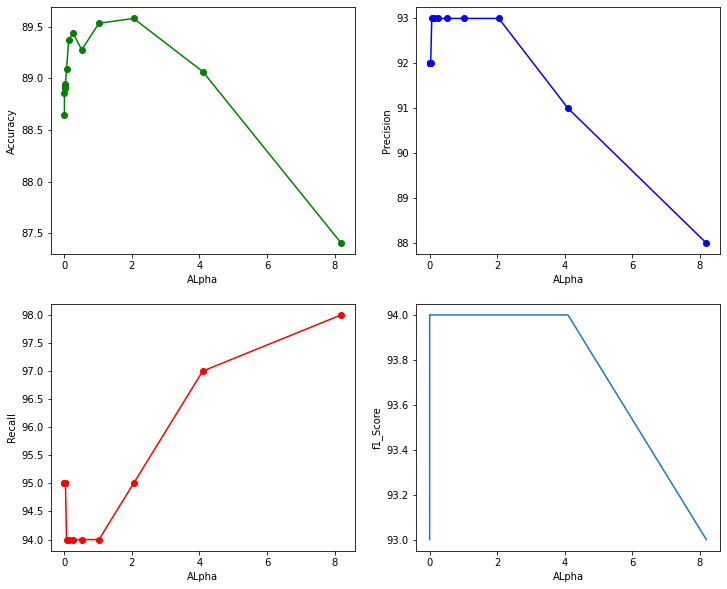

In [ ]:
plt.figure( figsize = (12,10) )

plt.subplot(2,2,1)
plt.plot(alpha_list,accuracy_list,'go-')
plt.xlabel("ALpha")
plt.ylabel("Accuracy")

plt.subplot(2,2,2)
plt.plot(alpha_list,precision_list,'bo-')
plt.xlabel("ALpha")
plt.ylabel("Precision")

plt.subplot(2,2,3)
plt.plot(alpha_list,recall_list,'ro-')
plt.xlabel("ALpha")
plt.ylabel("Recall")

plt.subplot(2,2,4)
plt.plot(alpha_list,f1_Score_list)
plt.xlabel("ALpha")
plt.ylabel("f1_Score")

print("Optimal ALpha according to Accuracy = ", alpha_list[accuracy_list.index(max(accuracy_list))])
print("Optimal ALpha according to Precision = ", alpha_list[precision_list.index(max(precision_list))])
print("Optimal ALpha according to F1_score = ", alpha_list[f1_Score_list.index(max(f1_Score_list))])

so Optimal alpha is around 2 accoridng to Accuracy, Precision and F1 score

Recall requires higher value of alpha but then we would have to compromise with accuracy and precision.

ROC is prefered as the scoring metric over the precision and the recall for cross validation 

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/


AUC and ROC are used only in Binary class classification problems

For Imbalanced Data set AUC can be high for even Dumb Model .

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.72 µs


100%|██████████| 13/13 [00:00<00:00, 57.71it/s]


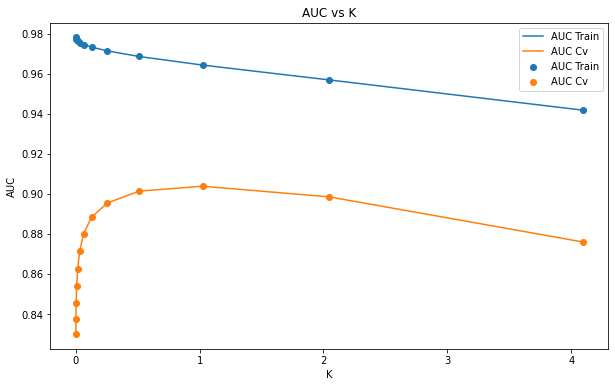

Best Alpha according to AUC-Roc is =  2.048


In [ ]:
%time
from sklearn.metrics import roc_auc_score


auc_cv     = []
auc_train  = []
alpha_list = []

alpha = 0.001 

while alpha <= 6:
  alpha_list.append(np.round(alpha,3))
  alpha = alpha*2


for i in tqdm(alpha_list):

  clf = MultinomialNB(alpha = i)

  clf.fit(BOW_X_train,Y_train)
  y_hat = clf.predict_proba(BOW_X_cv) # predict probabilities.
  pos_prob = y_hat[:,1]               # selecting probabilities of positive class only.
  auc_cv.append(roc_auc_score(Y_cv,pos_prob))

  y_hat = clf.predict_proba(BOW_X_train)
  pos_prob = y_hat[:,1]
  auc_train.append(roc_auc_score(Y_train,pos_prob)) # appending the auc_score of different alpha for training data.


plt.figure( figsize = (10,6) )

plt.plot(alpha_list,auc_train,label = "AUC Train")
plt.scatter(alpha_list,auc_train,label = "AUC Train")

plt.plot(alpha_list,auc_cv,label = 'AUC Cv')
plt.scatter(alpha_list,auc_cv,label = 'AUC Cv')

plt.title("AUC vs K")
plt.xlabel('K')
plt.ylabel('AUC')
plt.legend() 

plt.show()

difference_list = np.array(auc_train) - np.array(auc_cv)
minimum_difference_index = np.argmin(difference_list)

print("Best Alpha according to AUC-Roc is = ",alpha_list[minimum_difference_index])

Best Alpha according to AUC-Roc is =  2.048 , which aligning optimal k of accuracy, precision .

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


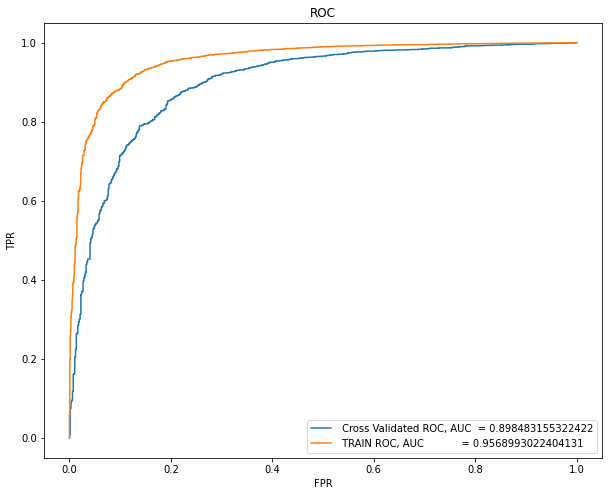

In [ ]:
%time

from sklearn.metrics import   roc_auc_score

clf = MultinomialNB(alpha = 2.048)

clf.fit(BOW_X_train,Y_train)

y_hat = clf.predict_proba(BOW_X_cv)
pos_prob_cv = y_hat[:,1]

fpr_test, tpr_test, thresholds = roc_curve(Y_cv,pos_prob_cv)

y_hat = clf.predict_proba(BOW_X_train)
pos_prob_train = y_hat[:,1]

fpr_train, tpr_train, thresholds = roc_curve(Y_train,pos_prob_train)

plt.figure(figsize=(10,8))

plt.plot(fpr_test, tpr_test ,label = " Cross Validated ROC, AUC  = " + str(roc_auc_score(Y_cv,pos_prob_cv)))
plt.plot(fpr_train,tpr_train,label = " TRAIN ROC, AUC            = " + str(roc_auc_score(Y_train,pos_prob_train)))

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

0.89 AUC is very good, means our model is able to distinguish positive class points from negative class points 89 percent of the times.

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

def plot_confusionMatrix(optimal_alpha,X_train,X_test,Y_train,Y_test):
  # plotting Confusion Matrix

  clf = MultinomialNB(alpha = optimal_alpha)

  clf.fit(X_train,Y_train)
  pred = clf.predict(X_test)

  print(classification_report(Y_test, pred))
  plot_confusion_matrix(clf, X_test, Y_test)


  plt.show()

              precision    recall  f1-score   support

           0       0.69      0.58      0.63       995
           1       0.92      0.95      0.94      5392

    accuracy                           0.89      6387
   macro avg       0.81      0.77      0.79      6387
weighted avg       0.89      0.89      0.89      6387



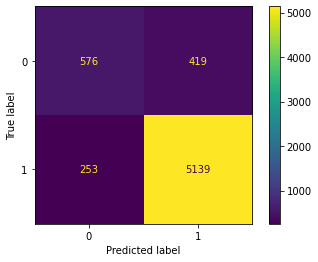

In [ ]:
plot_confusionMatrix(2.048,BOW_X_train,BOW_X_test,Y_train,Y_test)

In imbalanced datasets, the goal is to improve recall without hurting precision. These goals, however, are often conflicting, since in order to increase the TP for the minority class, the number of FP is also often increased, resulting in reduced precision.

https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/

https://www.codegrepper.com/code-examples/python/skplt.metrics.plot_confusion_matrix

https://towardsdatascience.com/7-over-sampling-techniques-to-handle-imbalanced-data-ec51c8db349f

## <h3> BOW(Bi-gram)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range = (2,2),max_features= 5000)

vectorizer.fit(X_train) # fitting on the training data,building the vocabulary and stuff.

BOW_X_train = vectorizer.transform(X_train) 
BOW_X_cv    = vectorizer.transform(X_cv)
BOW_X_test  = vectorizer.transform(X_test)

In [ ]:
print("some feature names:--",vectorizer.get_feature_names()[:10])

print("BOW_X_train",BOW_X_train.shape)
print("BOW_X_cv   ",BOW_X_cv.shape)
print("BOW_X_test ",BOW_X_test.shape)

print(type(BOW_X_train))

some feature names:-- ['able buy', 'able eat', 'able find', 'able get', 'able make', 'able order', 'able purchase', 'able use', 'absolute best', 'absolute favorite']
BOW_X_train (8687, 5000)
BOW_X_cv    (4280, 5000)
BOW_X_test  (6387, 5000)
<class 'scipy.sparse.csr.csr_matrix'>


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


100%|██████████| 13/13 [00:00<00:00, 62.87it/s]


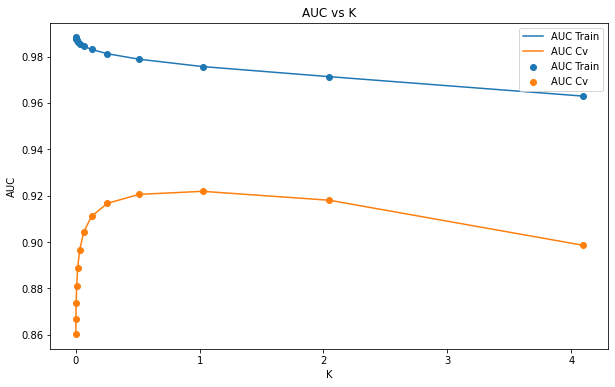

Best Alpha according to AUC-Roc is =  2.048


In [ ]:
%time
from sklearn.metrics import roc_auc_score


auc_cv     = []
auc_train  = []
alpha_list = []

alpha = 0.001 

while alpha <= 6:
  alpha_list.append(np.round(alpha,3))
  alpha = alpha*2


for i in tqdm(alpha_list):

  clf = MultinomialNB(alpha = i)

  clf.fit(BOW_X_train,Y_train)
  y_hat = clf.predict_proba(BOW_X_cv) # predict probabilities.
  pos_prob = y_hat[:,1]               # selecting probabilities of positive class only.
  auc_cv.append(roc_auc_score(Y_cv,pos_prob))

  y_hat = clf.predict_proba(BOW_X_train)
  pos_prob = y_hat[:,1]
  auc_train.append(roc_auc_score(Y_train,pos_prob)) # appending the auc_score of different alpha for training data.


plt.figure( figsize = (10,6) )

plt.plot(alpha_list,auc_train,label = "AUC Train")
plt.scatter(alpha_list,auc_train,label = "AUC Train")

plt.plot(alpha_list,auc_cv,label = 'AUC Cv')
plt.scatter(alpha_list,auc_cv,label = 'AUC Cv')

plt.title("AUC vs K")
plt.xlabel('K')
plt.ylabel('AUC')
plt.legend() 

plt.show()

difference_list = np.array(auc_train) - np.array(auc_cv)
minimum_difference_index = np.argmin(difference_list)

print("Best Alpha according to AUC-Roc is = ",alpha_list[minimum_difference_index])

optimal Alpha is same as that of unigram

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.44 µs


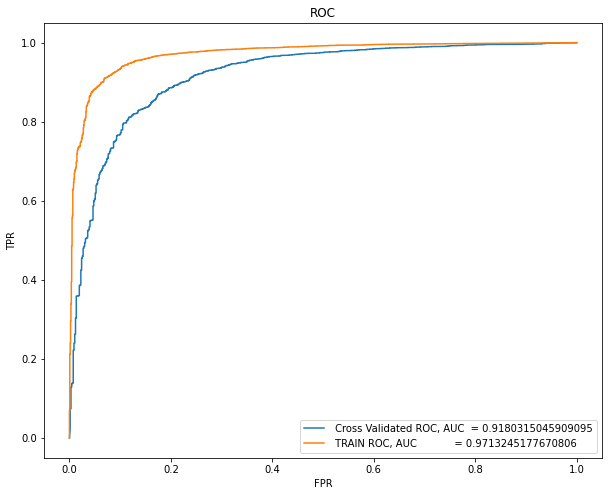

In [ ]:
%time

from sklearn.metrics import   roc_auc_score

clf = MultinomialNB(alpha = 2.048)

clf.fit(BOW_X_train,Y_train)

y_hat = clf.predict_proba(BOW_X_cv)
pos_prob_cv = y_hat[:,1]

fpr_test, tpr_test, thresholds = roc_curve(Y_cv,pos_prob_cv)

y_hat = clf.predict_proba(BOW_X_train)
pos_prob_train = y_hat[:,1]

fpr_train, tpr_train, thresholds = roc_curve(Y_train,pos_prob_train)

plt.figure(figsize=(10,8))

plt.plot(fpr_test, tpr_test ,label = " Cross Validated ROC, AUC  = " + str(roc_auc_score(Y_cv,pos_prob_cv)))
plt.plot(fpr_train,tpr_train,label = " TRAIN ROC, AUC            = " + str(roc_auc_score(Y_train,pos_prob_train)))

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

Better AUC for Bigram compared to simple Unigram , 91 percent AUC is very very good

              precision    recall  f1-score   support

           0       0.70      0.66      0.68       995
           1       0.94      0.95      0.94      5392

    accuracy                           0.90      6387
   macro avg       0.82      0.80      0.81      6387
weighted avg       0.90      0.90      0.90      6387



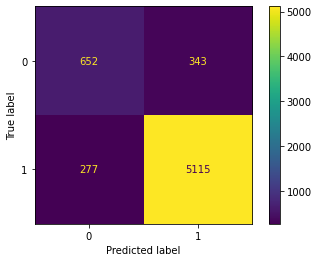

In [ ]:
plot_confusionMatrix(2.048,BOW_X_train,BOW_X_test,Y_train,Y_test)


our main diognals performance has improved


*   Precision , Recall and F1_score has imporved of negative points

*   Precision of positive points has also improved



## <h3> BOW (ngram_range(1,2)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,2),max_features=5000)

vectorizer.fit(X_train) # fitting on the training data,building the vocabulary and stuff.

BOW_X_train = vectorizer.transform(X_train) 
BOW_X_cv    = vectorizer.transform(X_cv)
BOW_X_test  = vectorizer.transform(X_test)

In [ ]:
from sklearn.preprocessing import Normalizer # let's feed normalize data 
Data_normalizer = Normalizer(norm='l2').fit(BOW_X_train)

BOW_X_train     = Data_normalizer.transform(BOW_X_train)
BOW_X_cv        = Data_normalizer.transform(BOW_X_cv)
BOW_X_test      = Data_normalizer.transform(BOW_X_test)

In [ ]:
print("some feature names:--",vectorizer.get_feature_names()[:10])

print("BOW_X_train",BOW_X_train.shape)
print("BOW_X_cv   ",BOW_X_cv.shape)
print("BOW_X_test ",BOW_X_test.shape)

print(type(BOW_X_train))

some feature names:-- ['able', 'able buy', 'able eat', 'able find', 'able get', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best', 'absolutely delicious']
BOW_X_train (8687, 5000)
BOW_X_cv    (4280, 5000)
BOW_X_test  (6387, 5000)
<class 'scipy.sparse.csr.csr_matrix'>


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


100%|██████████| 12/12 [00:00<00:00, 59.73it/s]


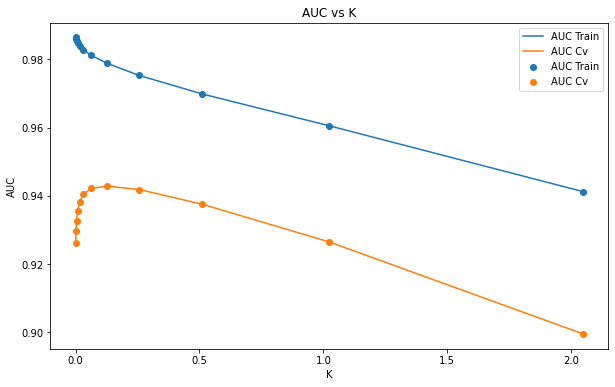

Best Alpha according to AUC-Roc is =  0.512


In [ ]:
%time
from sklearn.metrics import roc_auc_score


auc_cv     = []
auc_train  = []
alpha_list = []

alpha = 0.001 

while alpha <= 4:
  alpha_list.append(np.round(alpha,3))
  alpha = alpha*2


for i in tqdm(alpha_list):

  clf = MultinomialNB(alpha = i)

  clf.fit(BOW_X_train,Y_train)
  y_hat = clf.predict_proba(BOW_X_cv) # predict probabilities.
  pos_prob = y_hat[:,1]               # selecting probabilities of positive class only.
  auc_cv.append(roc_auc_score(Y_cv,pos_prob))

  y_hat = clf.predict_proba(BOW_X_train)
  pos_prob = y_hat[:,1]
  auc_train.append(roc_auc_score(Y_train,pos_prob)) # appending the auc_score of different alpha for training data.


plt.figure( figsize = (10,6) )

plt.plot(alpha_list,auc_train,label = "AUC Train")
plt.scatter(alpha_list,auc_train,label = "AUC Train")

plt.plot(alpha_list,auc_cv,label = 'AUC Cv')
plt.scatter(alpha_list,auc_cv,label = 'AUC Cv')

plt.title("AUC vs K")
plt.xlabel('K')
plt.ylabel('AUC')
plt.legend() 

plt.show()

difference_list = np.array(auc_train) - np.array(auc_cv)
minimum_difference_index = np.argmin(difference_list)

print("Best Alpha according to AUC-Roc is = ",alpha_list[minimum_difference_index])

Our Alplha has reduced from 2.048 to 0.512 , Let's see if there is an improvement in performance or not.

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


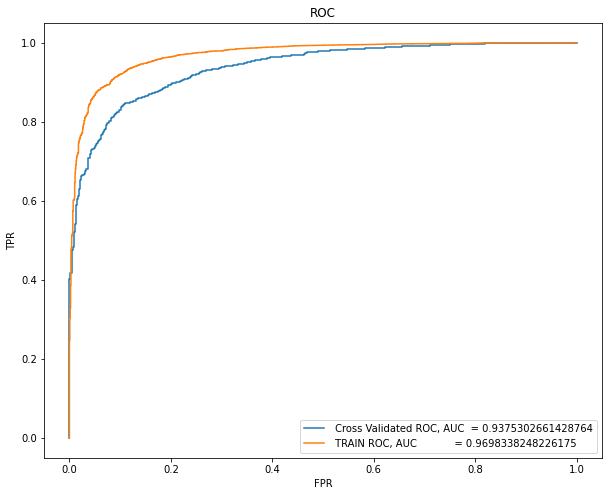

In [ ]:
%time

from sklearn.metrics import   roc_auc_score

clf = MultinomialNB(alpha = 0.512)

clf.fit(BOW_X_train,Y_train)

y_hat = clf.predict_proba(BOW_X_cv)
pos_prob_cv = y_hat[:,1]

fpr_test, tpr_test, thresholds = roc_curve(Y_cv,pos_prob_cv)

y_hat = clf.predict_proba(BOW_X_train)
pos_prob_train = y_hat[:,1]

fpr_train, tpr_train, thresholds = roc_curve(Y_train,pos_prob_train)

plt.figure(figsize=(10,8))

plt.plot(fpr_test, tpr_test ,label = " Cross Validated ROC, AUC  = " + str(roc_auc_score(Y_cv,pos_prob_cv)))
plt.plot(fpr_train,tpr_train,label = " TRAIN ROC, AUC            = " + str(roc_auc_score(Y_train,pos_prob_train)))

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

Auc has increased from 0.91 to 0.93 ⚡

The lesser the difference in train and test AUC , means lesser is the overfitting 

              precision    recall  f1-score   support

           0       0.93      0.16      0.27       995
           1       0.87      1.00      0.93      5392

    accuracy                           0.87      6387
   macro avg       0.90      0.58      0.60      6387
weighted avg       0.88      0.87      0.82      6387



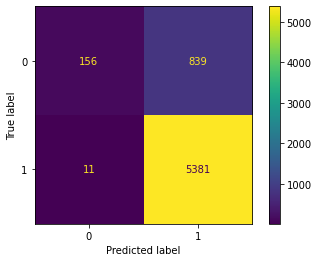

In [ ]:
plot_confusionMatrix(0.512,BOW_X_train,BOW_X_test,Y_train,Y_test)

* Recall of positive points is maximum

* Precision of negative points has increased vastly 

* Recall and f1 score performance is poor of negative class

<h3> Feature Importance </h3>




https://numpy.org/doc/stable/reference/generated/numpy.argsort.html

In [ ]:
clf = MultinomialNB(alpha = 0.512) # taking optimal Alpha from ngram_range(1,2)

clf.fit(BOW_X_train,Y_train)

features = clf.feature_log_prob_
feature_names = vectorizer.get_feature_names()

print("Features shape ",features.shape)

negative_features = features[0]
positive_features = features[1]

sorted_negative_feature = np.argsort(negative_features)[::-1]
sorted_positive_feature = np.argsort(positive_features)[::-1]

Features shape  (2, 5000)


In [ ]:
print("Negative feature top 10 :")
print("-"*30)
for i in list(sorted_negative_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n Positive feature top 10 :")
print("-"*30)
for i in list(sorted_positive_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Negative feature top 10 :
------------------------------
not	 -->	-3.522510  
like	 -->	-4.687490  
would	 -->	-4.870570  
product	 -->	-4.939515  
taste	 -->	-4.970110  
one	 -->	-5.259010  
good	 -->	-5.366193  
flavor	 -->	-5.473666  
no	 -->	-5.475969  
coffee	 -->	-5.489217  

 Positive feature top 10 :
------------------------------
not	 -->	-3.896907  
great	 -->	-4.576673  
like	 -->	-4.630117  
good	 -->	-4.648139  
love	 -->	-4.887182  
coffee	 -->	-4.941034  
one	 -->	-4.945804  
product	 -->	-5.037362  
taste	 -->	-5.077175  
flavor	 -->	-5.177298  


# BOW(ngram_range(1,3)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,3),max_features=10000)

vectorizer.fit(X_train) # fitting on the training data,building the vocabulary and stuff.

BOW_X_train = vectorizer.transform(X_train) 
BOW_X_cv    = vectorizer.transform(X_cv)
BOW_X_test  = vectorizer.transform(X_test)

In [ ]:
from sklearn.preprocessing import Normalizer
Data_normalizer = Normalizer(norm='l2').fit(BOW_X_train)

BOW_X_train     = Data_normalizer.transform(BOW_X_train)
BOW_X_cv        = Data_normalizer.transform(BOW_X_cv)
BOW_X_test      = Data_normalizer.transform(BOW_X_test)

In [ ]:
print("some feature names:--",vectorizer.get_feature_names()[:10])

print("BOW_X_train",BOW_X_train.shape)
print("BOW_X_cv   ",BOW_X_cv.shape)
print("BOW_X_test ",BOW_X_test.shape)

print(type(BOW_X_train))

some feature names:-- ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able make', 'able order', 'able purchase', 'able use']
BOW_X_train (8687, 10000)
BOW_X_cv    (4280, 10000)
BOW_X_test  (6387, 10000)
<class 'scipy.sparse.csr.csr_matrix'>


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.15 µs


100%|██████████| 12/12 [00:00<00:00, 64.10it/s]


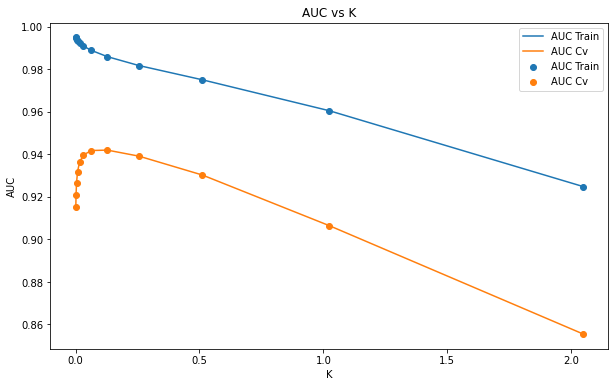

Best Alpha according to AUC-Roc is =  0.256


In [ ]:
%time
from sklearn.metrics import roc_auc_score


auc_cv     = []
auc_train  = []
alpha_list = []

alpha = 0.001 

while alpha <= 4:
  alpha_list.append(np.round(alpha,3))
  alpha = alpha*2


for i in tqdm(alpha_list):

  clf = MultinomialNB(alpha = i)

  clf.fit(BOW_X_train,Y_train)
  y_hat = clf.predict_proba(BOW_X_cv) # predict probabilities.
  pos_prob = y_hat[:,1]               # selecting probabilities of positive class only.
  auc_cv.append(roc_auc_score(Y_cv,pos_prob))

  y_hat = clf.predict_proba(BOW_X_train)
  pos_prob = y_hat[:,1]
  auc_train.append(roc_auc_score(Y_train,pos_prob)) # appending the auc_score of different alpha for training data.


plt.figure( figsize = (10,6) )

plt.plot(alpha_list,auc_train,label = "AUC Train")
plt.scatter(alpha_list,auc_train,label = "AUC Train")

plt.plot(alpha_list,auc_cv,label = 'AUC Cv')
plt.scatter(alpha_list,auc_cv,label = 'AUC Cv')

plt.title("AUC vs K")
plt.xlabel('K')
plt.ylabel('AUC')
plt.legend() 

plt.show()

difference_list = np.array(auc_train) - np.array(auc_cv)
minimum_difference_index = np.argmin(difference_list)

print("Best Alpha according to AUC-Roc is = ",alpha_list[minimum_difference_index])

K has decreased even more from 0.512 to 0.256

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs


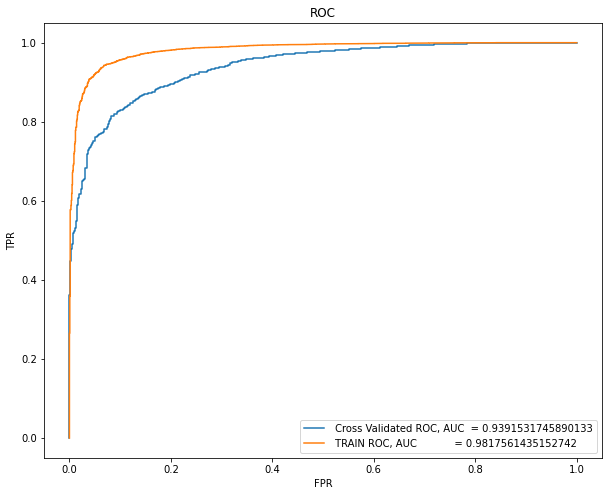

In [ ]:
%time

from sklearn.metrics import   roc_auc_score

clf = MultinomialNB(alpha = 0.256)

clf.fit(BOW_X_train,Y_train)

y_hat = clf.predict_proba(BOW_X_cv)
pos_prob_cv = y_hat[:,1]

fpr_test, tpr_test, thresholds = roc_curve(Y_cv,pos_prob_cv)

y_hat = clf.predict_proba(BOW_X_train)
pos_prob_train = y_hat[:,1]

fpr_train, tpr_train, thresholds = roc_curve(Y_train,pos_prob_train)

plt.figure(figsize=(10,8))

plt.plot(fpr_test, tpr_test ,label = " Cross Validated ROC, AUC  = " + str(roc_auc_score(Y_cv,pos_prob_cv)))
plt.plot(fpr_train,tpr_train,label = " TRAIN ROC, AUC            = " + str(roc_auc_score(Y_train,pos_prob_train)))

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

AUC is very very good in this case also but The difference in ROC of train and cross validated data is high Hence it may lead to overfitting

              precision    recall  f1-score   support

           0       0.92      0.20      0.33       995
           1       0.87      1.00      0.93      5392

    accuracy                           0.87      6387
   macro avg       0.90      0.60      0.63      6387
weighted avg       0.88      0.87      0.84      6387



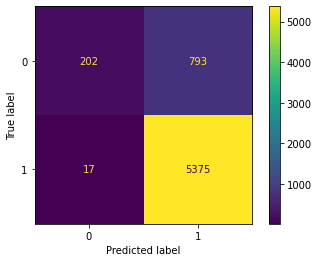

In [ ]:
plot_confusionMatrix(0.256,BOW_X_train,BOW_X_test,Y_train,Y_test)

Recall and f1 score of -ve class has increased

precision of +ve class has decreased 

# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer  = TfidfVectorizer(ngram_range = (1,2),norm = 'l2',min_df = 10,max_df = 0.7,max_features=5000)

tf_idf_X_train = vectorizer.fit_transform(X_train)
tf_idf_X_cv    = vectorizer.transform(X_cv)
tf_idf_X_test  = vectorizer.transform(X_test)

In [ ]:
print("some feature names:--",vectorizer.get_feature_names()[:10])

print("tf_idf_X_train",tf_idf_X_train.shape)
print("tf_idf_X_cv   ",tf_idf_X_cv.shape)
print("tf_idf_X_test ",tf_idf_X_test.shape)

print(type(tf_idf_X_train))

some feature names:-- ['able', 'able buy', 'able eat', 'able find', 'able get', 'absolute', 'absolute favorite', 'absolutely', 'absolutely best', 'absolutely delicious']
tf_idf_X_train (8687, 5000)
tf_idf_X_cv    (4280, 5000)
tf_idf_X_test  (6387, 5000)
<class 'scipy.sparse.csr.csr_matrix'>


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


100%|██████████| 13/13 [00:00<00:00, 64.05it/s]


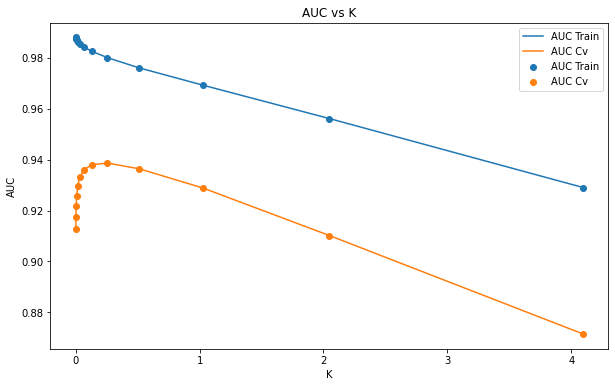

Best Alpha according to AUC-Roc is =  0.512


In [ ]:
%time
from sklearn.metrics import roc_auc_score


auc_cv     = []
auc_train  = []
alpha_list = []

alpha = 0.001 

while alpha <= 6:
  alpha_list.append(np.round(alpha,3))
  alpha = alpha*2


for i in tqdm(alpha_list):

  clf = MultinomialNB(alpha = i)

  clf.fit(tf_idf_X_train,Y_train)
  y_hat = clf.predict_proba(tf_idf_X_cv) # predict probabilities.
  pos_prob = y_hat[:,1]               # selecting probabilities of positive class only.
  auc_cv.append(roc_auc_score(Y_cv,pos_prob))

  y_hat = clf.predict_proba(tf_idf_X_train)
  pos_prob = y_hat[:,1]
  auc_train.append(roc_auc_score(Y_train,pos_prob)) # appending the auc_score of different alpha for training data.


plt.figure( figsize = (10,6) )

plt.plot(alpha_list,auc_train,label = "AUC Train")
plt.scatter(alpha_list,auc_train,label = "AUC Train")

plt.plot(alpha_list,auc_cv,label = 'AUC Cv')
plt.scatter(alpha_list,auc_cv,label = 'AUC Cv')

plt.title("AUC vs K")
plt.xlabel('K')
plt.ylabel('AUC')
plt.legend() 

plt.show()

difference_list = np.array(auc_train) - np.array(auc_cv)
minimum_difference_index = np.argmin(difference_list)

print("Best Alpha according to AUC-Roc is = ",alpha_list[minimum_difference_index])

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.2 µs


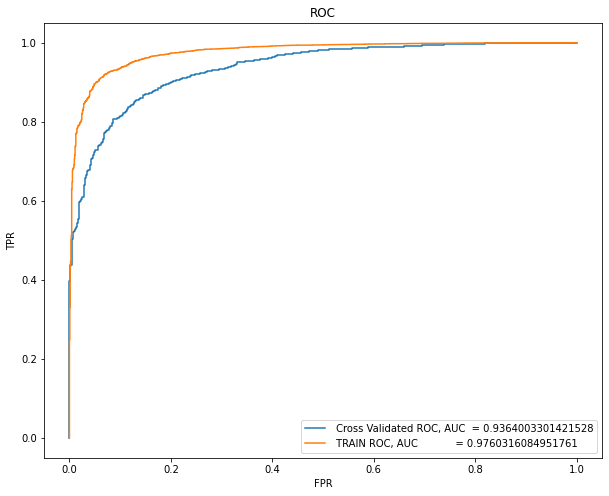

In [ ]:
%time


clf = MultinomialNB(alpha = 0.512)

clf.fit(tf_idf_X_train,Y_train)

y_hat = clf.predict_proba(tf_idf_X_cv)
pos_prob_cv = y_hat[:,1]

fpr_test, tpr_test, thresholds = roc_curve(Y_cv,pos_prob_cv)

y_hat = clf.predict_proba(tf_idf_X_train)
pos_prob_train = y_hat[:,1]

fpr_train, tpr_train, thresholds = roc_curve(Y_train,pos_prob_train)

plt.figure(figsize=(10,8))

plt.plot(fpr_test, tpr_test ,label = " Cross Validated ROC, AUC  = " + str(roc_auc_score(Y_cv,pos_prob_cv)))
plt.plot(fpr_train,tpr_train,label = " TRAIN ROC, AUC            = " + str(roc_auc_score(Y_train,pos_prob_train)))

plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

plt.show()

very same ROC comparing to BOW(ngram_range(1,2)

              precision    recall  f1-score   support

           0       0.92      0.24      0.39       995
           1       0.88      1.00      0.93      5392

    accuracy                           0.88      6387
   macro avg       0.90      0.62      0.66      6387
weighted avg       0.88      0.88      0.85      6387



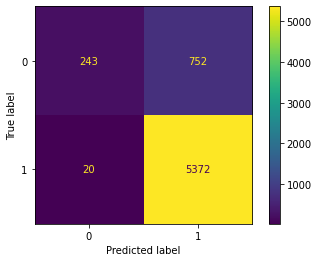

In [ ]:
plot_confusionMatrix(0.512,tf_idf_X_train,tf_idf_X_test,Y_train,Y_test)

-ve class

*   Precision Improved
*   Recall    Improved
*   f1 score  Improved

+ve class
*  precision improved
*  Recall is same 
*  f1 score is same

Area Under the Curve of ROC is similar to BOW(ngram_range(1,2))


<h3> Feature Importance </h3>

https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes

In [ ]:
clf = MultinomialNB(alpha = 0.512) # taking optimal Alpha from ngram_range(1,2)

clf.fit(tf_idf_X_train,Y_train)

features = clf.feature_log_prob_
feature_names = vectorizer.get_feature_names()

print("Features shape ",features.shape)

negative_features = features[0]
positive_features = features[1]

sorted_negative_feature = np.argsort(negative_features)[::-1]
sorted_positive_feature = np.argsort(positive_features)[::-1]

Features shape  (2, 5000)


In [ ]:
print("Negative feature top 10 :")
print("-"*30)
for i in list(sorted_negative_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],negative_features[i]))
    
print("\n Positive feature top 10 :")
print("-"*30)
for i in list(sorted_positive_feature[0:10]):
    print("%s\t -->\t%f  "%(feature_names[i],positive_features[i]))

Negative feature top 10 :
------------------------------
not	 -->	-4.588775  
like	 -->	-5.444759  
would	 -->	-5.489124  
product	 -->	-5.528021  
taste	 -->	-5.575316  
coffee	 -->	-5.910892  
one	 -->	-5.913113  
no	 -->	-5.987873  
flavor	 -->	-6.013967  
even	 -->	-6.056274  

 Positive feature top 10 :
------------------------------
not	 -->	-4.968811  
great	 -->	-5.275102  
good	 -->	-5.361271  
coffee	 -->	-5.362972  
like	 -->	-5.391964  
love	 -->	-5.477905  
one	 -->	-5.597446  
tea	 -->	-5.621846  
product	 -->	-5.624947  
taste	 -->	-5.696545  


# Conclusions

In [ ]:
from prettytable import PrettyTable    

x = PrettyTable()

x.field_names = ["Vectorizer","ngram_range", "Hyperameter(alpha)","AUC"]

x.add_row( ["BOW",(1,1),2.048,0.911] )
x.add_row( ["BOW",(2,2),2.048,0.911] )

x.add_row( ["BOW",(1,2),0.512,0.937] )
x.add_row( ["BOW",(1,3),0.256,0.939] )

x.add_row(["TFIDF",(1,2),0.512,0.936])

print(x)

+------------+-------------+--------------------+-------+
| Vectorizer | ngram_range | Hyperameter(alpha) |  AUC  |
+------------+-------------+--------------------+-------+
|    BOW     |    (1, 1)   |       2.048        | 0.911 |
|    BOW     |    (2, 2)   |       2.048        | 0.911 |
|    BOW     |    (1, 2)   |       0.512        | 0.937 |
|    BOW     |    (1, 3)   |       0.256        | 0.939 |
|   TFIDF    |    (1, 2)   |       0.512        | 0.936 |
+------------+-------------+--------------------+-------+
